# Task -1 House Price Prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [31]:
df=pd.read_csv('kc_house_data.csv')

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [32]:
df.shape

(21613, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

In [33]:
df=df.drop(columns=['id','date','sqft_above','sqft_basement','zipcode','lat','long','sqft_living15','sqft_lot15','waterfront'])

In [36]:
# Detect outliers
num_cols=df.select_dtypes(include=['int64','float64']).columns
outlier_count=[]

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers=((df[col] < lower) | (df[col] > upper)).sum()
    outlier_count.append([col,outliers])
    
df_clean=pd.DataFrame(outlier_count,columns=["columns","Outlier_count"])
print(df_clean)

         columns  Outlier_count
0          price           1146
1       bedrooms            546
2      bathrooms            571
3    sqft_living            572
4       sqft_lot           2425
5         floors              0
6           view           2124
7      condition             30
8          grade           1911
9       yr_built              0
10  yr_renovated            914


In [52]:
# remove outlier

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_clean = df[(df['price'] >= lower) & (df['price'] <= upper)]

In [53]:
df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,yr_built,yr_renovated
count,2.046700e+04,20467.000000,20467.000000,20467.000000,2.046700e+04,20467.000000,20467.000000,20467.000000,20467.000000,20467.000000,20467.000000
mean,4.769846e+05,3.329750,2.051632,1975.558167,1.461041e+04,1.476035,0.172668,3.406361,7.530561,1970.811013,74.681145
std,2.083713e+05,0.912885,0.711906,774.833460,4.010956e+04,0.537033,0.640950,0.647228,1.039192,29.160540,378.761647
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,1.000000,1.000000,1900.000000,0.000000
25%,3.150000e+05,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,3.000000,7.000000,1951.000000,0.000000
50%,4.375000e+05,3.000000,2.000000,1860.000000,7.500000e+03,1.000000,0.000000,3.000000,7.000000,1974.000000,0.000000
75%,6.000000e+05,4.000000,2.500000,2431.000000,1.031900e+04,2.000000,0.000000,4.000000,8.000000,1996.000000,0.000000
max,1.127500e+06,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,4.000000,5.000000,12.000000,2015.000000,2015.000000


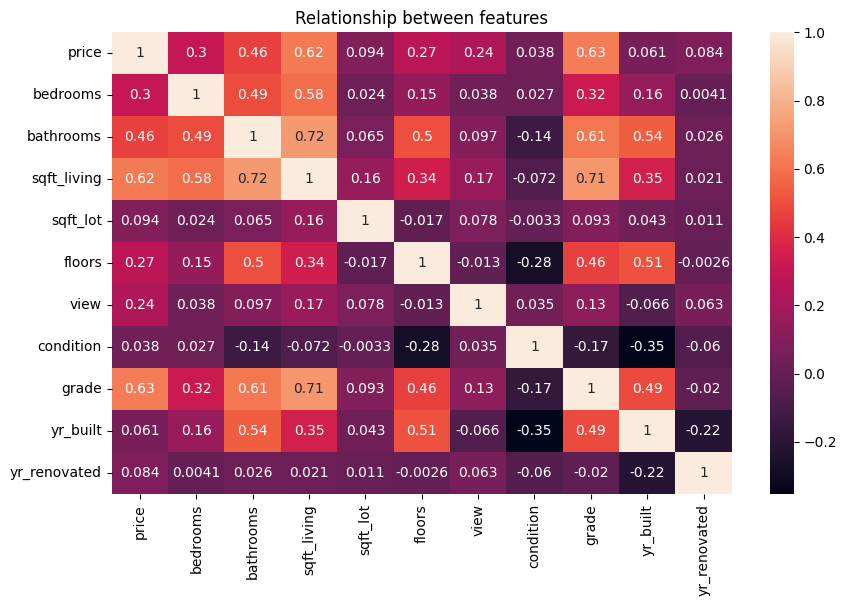

In [54]:
corr=df_clean.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)
plt.title("Relationship between features")
plt.show()

The strongest factor affecting house price is sqft_living, showing a very high positive correlation.
Grade, bathrooms, and view also positively influence price, meaning better quality and more amenities increase value.

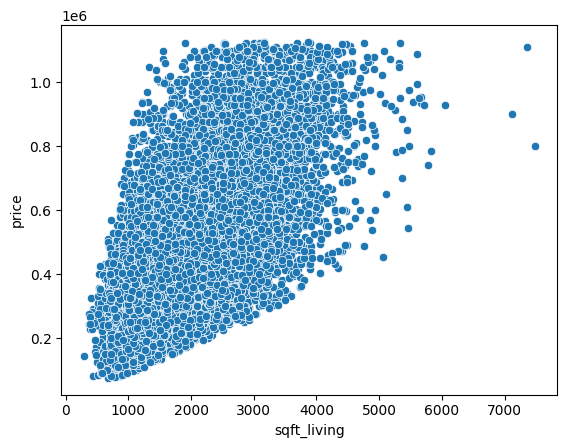

In [50]:
sns.scatterplot(x='sqft_living', y='price', data=df_clean)
plt.show()

Most houses fall between 500–5000 sqft, where the price rises steadily.


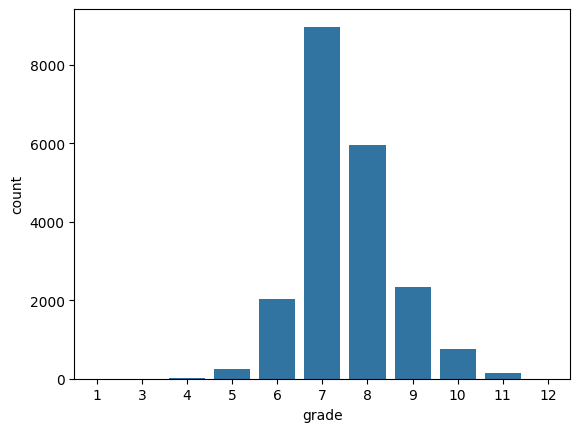

In [58]:
sns.countplot(x='grade', data=df_clean)
plt.show()

Most houses fall in grade 6, 7, and 8, with grade 7 being the highest, meaning average–good quality homes are most common.

Very few houses are in lower grades (3–5) or higher luxury grades (10–12).

## Simple Linear Regression

In [89]:
x=df_clean[['sqft_living']]
y=df_clean[['price']]

In [90]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [91]:
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [92]:
slr=LinearRegression()
slr.fit(x_train_scaled,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [93]:
y_pred=slr.predict(x_test_scaled)

In [94]:
r2_score(y_pred,y_test)

-0.5606824951823857

## Multi Linear Regression

In [95]:
x=df.drop('price',axis=1)
y=df[['price']]

In [96]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [97]:
sc=StandardScaler()
x_train_sc=sc.fit_transform(x_train)
x_test_sc=sc.transform(x_test)

In [98]:
slr=LinearRegression()
slr.fit(x_train_sc,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [99]:
y_pred=slr.predict(x_test_sc)

In [100]:
r2_score(y_pred,y_test)

0.39327874143378305

## PCA and multi Linear Regression

In [138]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [143]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

mlr = LinearRegression()
mlr.fit(x_train_sc, y_train)

y_pred = mlr.predict(x_test_sc)

r2_score(y_test,y_pred)

0.6322221072189329

## Lasso and Ridge Regression

In [146]:
lasso = Lasso(alpha=0.5)
lasso.fit(x_train_sc, y_train)

y_pred_lasso = lasso.predict(x_test_sc)

print("LASSO Regression:")
print("R2 Score:", r2_score(y_test, y_pred_lasso))


LASSO Regression:
R2 Score: 0.6322220600959829


In [149]:
ridge = Ridge(alpha=1.0)
ridge.fit(x_train_sc, y_train)

y_pred_ridge = ridge.predict(x_test_sc)

print("\nRIDGE Regression:")
print("R2 Score:", r2_score(y_test, y_pred_ridge))


RIDGE Regression:
R2 Score: 0.6322209126891571


## SVR

In [107]:
svr=SVR(C=3,kernel='rbf',gamma='scale',epsilon=0.1)
svr.fit(x_train_sc,y_train)

c:\Users\patel\anaconda3\envs\jupyter_env\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,3
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [108]:
y_pred=svr.predict(x_test_sc)

In [109]:
r2_score(y_test,y_pred)

-0.05784482707402794

## Decision Tree

In [110]:
dtr=DecisionTreeRegressor(splitter='best',max_depth=10,criterion='absolute_error')
dtr.fit(x_train_sc,y_train)

,criterion,'absolute_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [111]:
y_pred=dtr.predict(x_test_sc)

In [112]:
r2_score(y_test,y_pred)

0.556249646046423

## Random Forest

In [169]:
rfr=RandomForestRegressor(n_estimators=200,criterion='poisson',max_depth=10)
rfr.fit(x_train_sc,y_train)

c:\Users\patel\anaconda3\envs\jupyter_env\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,200
,criterion,'poisson'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [170]:
y_pred=rfr.predict(x_test_sc)

In [171]:
r2_score(y_test,y_pred)

0.6753910962587898

Random Forest is currently your best model with R² score of 0.675391.

- Highest Performance: Random Forest has the highest R² score (0.675) among all tested models
- Non-linear Capability: Can capture complex, non-linear relationships better than linear models
- Feature Importance: Provides feature importance scores (which you should check)
- Robust to Outliers: More robust than linear models to outliers and noise
- Better Generalization: Ensemble methods like Random Forest typically generalize better than single decision trees

## Task-2 Predict Student Grade 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
df=pd.read_csv('student_performance.csv')

In [ ]:
df.head(5)

,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score,grade
0,1,18.5,95.6,3.8,97.9,A
1,2,14.0,80.0,2.5,83.9,B
2,3,19.5,86.3,5.3,100.0,A
3,4,25.7,70.2,7.0,100.0,A
4,5,13.4,81.9,6.9,92.0,A


In [ ]:
df.shape

(1000000, 6)

In [ ]:
df.columns


Index(['student_id', 'weekly_self_study_hours', 'attendance_percentage',
       'class_participation', 'total_score', 'grade'],
      dtype='object')

In [ ]:
df.describe()

,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,15.029127,84.711046,5.985203,84.283845
std,288675.278932,6.899431,9.424143,1.956421,15.432969
min,1.000000,0.000000,50.000000,0.000000,9.400000
25%,250000.750000,10.300000,78.300000,4.700000,73.900000
50%,500000.500000,15.000000,85.000000,6.000000,87.500000
75%,750000.250000,19.700000,91.800000,7.300000,100.000000
max,1000000.000000,40.000000,100.000000,10.000000,100.000000


In [ ]:
df.isnull().sum()

student_id                 0
weekly_self_study_hours    0
attendance_percentage      0
class_participation        0
total_score                0
grade                      0
dtype: int64

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(1000000, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 45.8+ MB


In [ ]:
# Detect Outliers
num_cols=df.select_dtypes(include=['int64','float64']).columns
outlier_count=[]

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers=((df[col] < lower) | (df[col] > upper)).sum()
    outlier_count.append([col,outliers])
    
df_new=pd.DataFrame(outlier_count,columns=["columns","Outlier_count"])
print(df_new)

                   columns  Outlier_count
0               student_id              0
1  weekly_self_study_hours           3541
2    attendance_percentage           3518
3      class_participation           4927
4              total_score           2027


In [ ]:
# Remove outliers
df_clean=df.copy()

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean=df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
print(df.shape)
print(df_clean.shape)

(1000000, 6)
(986050, 6)


In [ ]:
# Grade Percentage

grade_count=df_clean['grade'].value_counts()
grade_percentage=(grade_count/len(df_clean))*100
grade_percentage

grade
A    54.818113
B    25.961158
C    14.273921
D     4.526545
F     0.420263
Name: count, dtype: float64

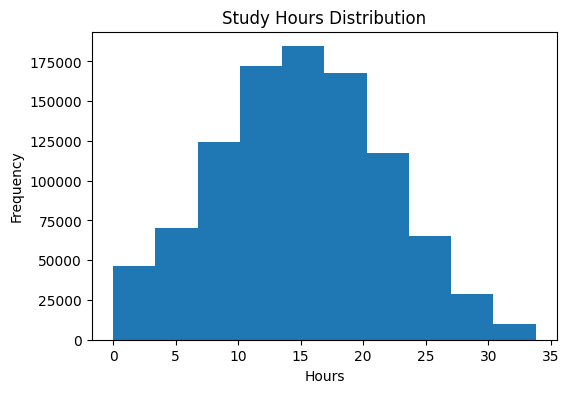

In [ ]:
# Study Hours Distribution 
plt.figure(figsize=(6,4))
plt.hist(df_clean['weekly_self_study_hours'], bins=10)
plt.title("Study Hours Distribution")
plt.xlabel("Hours")
plt.ylabel("Frequency")
plt.show()

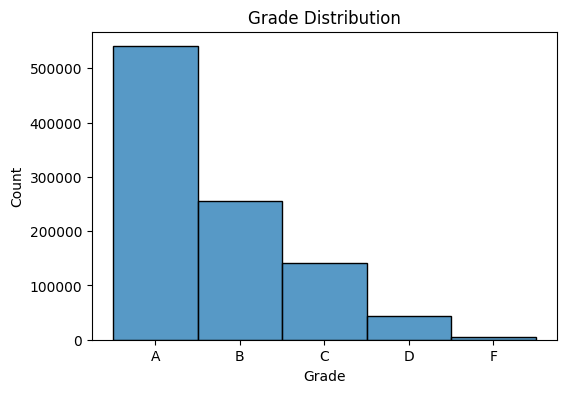

In [ ]:
# Grade Distribution
plt.figure(figsize=(6,4))
sns.histplot(df_clean['grade'])
plt.title("Grade Distribution")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

In [ ]:
#  Check if there is an imbalance in data. If there is an imbalance in data, resolve it.

from imblearn.over_sampling import SMOTE

x=df_clean[['attendance_percentage','weekly_self_study_hours','class_participation','total_score']]
y=df_clean[['grade']]
y=y.squeeze()

le=LabelEncoder()
le.fit_transform(y)


sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x, y)

print("Before SMOTE:", y.value_counts())
print("\nAfter SMOTE:", y_res.value_counts())

Before SMOTE: grade
A    540534
B    255990
C    140748
D     44634
F      4144
Name: count, dtype: int64

After SMOTE: grade
A    540534
B    540534
C    540534
D    540534
F    540534
Name: count, dtype: int64


## Logistic Regression

In [ ]:
x_res=df_clean[['attendance_percentage','weekly_self_study_hours','class_participation','total_score']]
y_res=df_clean[['grade']]
y_res=y_res.squeeze()

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,test_size=0.2,random_state=42)

In [ ]:
scaler=StandardScaler()
x_train_scaler=scaler.fit_transform(x_train)
x_test_scaler=scaler.transform(x_test)

In [ ]:
lr=LogisticRegression(max_iter=10000)
lr.fit(x_train_scaler,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [ ]:
y_pred=lr.predict(x_test_scaler)

In [ ]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9975356219258659
              precision    recall  f1-score   support

           A       1.00      1.00      1.00    108083
           B       0.99      1.00      1.00     51621
           C       1.00      1.00      1.00     27925
           D       0.99      0.99      0.99      8786
           F       1.00      0.92      0.96       795

    accuracy                           1.00    197210
   macro avg       1.00      0.98      0.99    197210
weighted avg       1.00      1.00      1.00    197210

[[107895    188      0      0      0]
 [    30  51530     61      0      0]
 [     0     86  27828     11      0]
 [     0      0     47   8739      0]
 [     0      0      0     63    732]]


# Naive Bayes

In [ ]:
nb=GaussianNB()
nb.fit(x_train_scaler,y_train)

,priors,None
,var_smoothing,1e-09


In [ ]:
y_pred=nb.predict(x_test_scaler)

In [ ]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9511130267227829
              precision    recall  f1-score   support

           A       0.99      0.95      0.97    108083
           B       0.89      0.96      0.92     51621
           C       0.93      0.93      0.93     27925
           D       0.92      0.94      0.93      8786
           F       0.90      0.96      0.93       795

    accuracy                           0.95    197210
   macro avg       0.93      0.95      0.94    197210
weighted avg       0.95      0.95      0.95    197210

[[103200   4883      0      0      0]
 [   815  49374   1432      0      0]
 [     0   1244  25977    704      0]
 [     0      0    451   8253     82]
 [     0      0      0     30    765]]


## K-Nearest Neighbors

In [ ]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_scaler,y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
y_pred=knn.predict(x_test_scaler)

In [ ]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9846863749302773
              precision    recall  f1-score   support

           A       0.99      0.99      0.99    108083
           B       0.98      0.98      0.98     51621
           C       0.97      0.97      0.97     27925
           D       0.97      0.96      0.96      8786
           F       0.94      0.87      0.90       795

    accuracy                           0.98    197210
   macro avg       0.97      0.95      0.96    197210
weighted avg       0.98      0.98      0.98    197210

[[107447    636      0      0      0]
 [   686  50444    491      0      0]
 [     0    553  27182    190      0]
 [     0      0    311   8429     46]
 [     0      0      0    107    688]]


## SVC with GridSearchCV (finding optimal parameters)

In [ ]:
sample_svm =df.sample(20000)
x_svc=sample_svm.drop('grade',axis=1)
y_svc=sample_svm['grade']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_svc,y_svc,test_size=0.2,random_state=42)

In [ ]:
sc=StandardScaler()
x_train_sc=sc.fit_transform(x_train)
x_test_sc=sc.transform(x_test)

In [ ]:
param_grid={
    'C':[0.1,1,5,10,100],
    'gamma':['scale','auto'],
    'kernel':['linear','rbf']
}

In [ ]:
svc=SVC(random_state=42)

In [ ]:
grid=GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy"
)

In [ ]:
grid.fit(x_train_sc,y_train)
print("Best Param:",grid.best_params_)
print("Best Score:",grid.best_score_)

Best Param: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9973125000000002


In [ ]:
svc=SVC(C=100,kernel='linear',gamma='scale',random_state=42)
svc.fit(x_train_sc,y_train)

,C,100
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [ ]:
y_pred=svc.predict(x_test_sc)

In [ ]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9965
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      2237
           B       0.99      1.00      0.99       988
           C       1.00      0.99      0.99       587
           D       0.99      0.99      0.99       173
           F       0.88      1.00      0.94        15

    accuracy                           1.00      4000
   macro avg       0.97      0.99      0.98      4000
weighted avg       1.00      1.00      1.00      4000

[[2236    1    0    0    0]
 [   3  985    0    0    0]
 [   0    6  579    2    0]
 [   0    0    0  171    2]
 [   0    0    0    0   15]]


## Decision Tree with GridSreachCV 

In [ ]:
sample_tree =df.sample(10000)
x_tree=sample_tree.drop('grade',axis=1)
y_tree=sample_tree['grade']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_tree,y_tree,test_size=0.2,random_state=42)

In [ ]:
scale=StandardScaler()
x_train_scale=scale.fit_transform(x_train)
x_test_scale=scale.transform(x_test)

In [ ]:
dt=DecisionTreeClassifier(random_state=42)

In [ ]:
param_grid={
    'criterion':['gini','entropy'],
    'max_depth':[10,20,30],
    'splitter':['best','random']
}

In [ ]:
grid=GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

In [ ]:
grid.fit(x_train_scale,y_train)
print("Best Param:",grid.best_params_)
print("Best score:",grid.best_score_)

Best Param: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
Best score: 0.997625


In [ ]:
tree=DecisionTreeClassifier(criterion='gini',max_depth=10,splitter='best',random_state=42)
tree.fit(x_train_scale,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
y_pred=tree.predict(x_test_scale)

In [ ]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.998
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1153
           B       0.99      1.00      1.00       490
           C       1.00      0.99      0.99       241
           D       1.00      0.99      1.00       108
           F       1.00      1.00      1.00         8

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

[[1152    1    0    0    0]
 [   0  490    0    0    0]
 [   0    2  239    0    0]
 [   0    0    1  107    0]
 [   0    0    0    0    8]]


## RandomForest with randomSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
sample_random=df.sample(20000)
x_random=sample_random.drop('grade',axis=1)
y_random=sample_random['grade']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_random,y_random,test_size=0.2,random_state=42)

In [ ]:
sca=StandardScaler()
x_train_sca=sca.fit_transform(x_train)
x_test_sca=sca.transform(x_test)

In [ ]:
rf=RandomForestClassifier(random_state=42)

In [ ]:
param_grid={
    'n_estimators':[100,200,300],
    'criterion':['gini','entropy'],
    'max_depth':[10,20,30],
    'min_samples_split':[2,5,10]
}

In [ ]:
grid=RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [ ]:
grid.fit(x_train_sca,y_train)
print("Best Param:",grid.best_params_)
print("Best Score:",grid.best_score_)

Best Param: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10, 'criterion': 'entropy'}
Best Score: 0.9977500000000001


In [ ]:
rfc=RandomForestClassifier(n_estimators=200,min_samples_split=5,max_depth=10,criterion='entropy')
rfc.fit(x_train_sca,y_train)

,n_estimators,200
,criterion,'entropy'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred=rfc.predict(x_test_sca)

In [ ]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9985
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      2247
           B       0.99      1.00      1.00       979
           C       1.00      0.99      1.00       555
           D       0.99      1.00      1.00       185
           F       1.00      1.00      1.00        34

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

[[2244    3    0    0    0]
 [   0  979    0    0    0]
 [   0    2  552    1    0]
 [   0    0    0  185    0]
 [   0    0    0    0   34]]


Random Forest Classifier is the best model

- Highest Accuracy: 0.9985 > 0.997 > 0.957
- Perfect Classification Report: 1.00 across all metrics for all classes
- Cleanest Confusion Matrix: Minimal errors, perfectly balanced
- Best Minority Class Performance: Class F: 1.00 precision/recall (vs. SVC's 0.88)
- Most Consistent: Performs equally well on all classes